
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2025<br>
<font color=3C99D size=5>
    Project-Phase2<br>
    Soft Actor Critic<br>
<font color=696880 size=4>
    Ali Najar-Mohmmad Shafizade-Armin Khosravi


<font size=5 color=cyan> Names: Pardis Moradi, Amir Reza Jafari

Student Numbers: 402106489, 402105835 </font>



In this notebook, we are going to get familiar with SAC algorithm. Soft Actor Critic (SAC) is an off-policy algorithm that maximizes a combination of expected return **and** entropy. Higher entropy results in higher exploration, which is an important concept in Reinforcement Learning.

## 📦 Setup and Dependencies

Install PyBullet for Physics based environments.

In [21]:
# # Remove old packages
# !pip uninstall -y gym pybullet_envs

# # Install new versions
# !pip install -q gymnasium pybullet gymnasium[box2d] gymnasium[accept-rom-license]

# # For PyBullet environments:
# !pip install -q pybullet

Import necessary packages.

In [22]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy
from torch.distributions import Normal

import warnings
warnings.filterwarnings('ignore')
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import pybullet_envs
np.bool8 = np.bool_
from tqdm.notebook import trange
from IPython.display import Video

## 📈 Utility codes

We will use this utility function to visualize the training progress.

In [23]:
def plot_learning_curve(x, filename, save_plot=True):
    avg_x = [np.mean(x[np.max([0, i - 100]):i]) for i in range(len(x))]
    plt.figure(dpi=200)
    plt.title('Learning Curve')
    plt.plot(range(len(x)), x, label='score', alpha=0.3)
    plt.plot(range(len(avg_x)), avg_x, label='average score')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    if save_plot:
        plt.savefig(filename + '.png')
    plt.show()

This class implements a **Replay Buffer** to store and sample transitions of the form $(s_t, a_t, r_t, s_{t+1}, d_t)$ to break correlation in updates for stability in mini-batch stochastic gradient descent.


In [24]:
class BatchSizeException(Exception):
    pass

class ReplayBuffer:
    def __init__(self, buffer_size, state_dims, action_dims):
        self.buffer_size = buffer_size
        self.ptr = 0
        self.is_full = False
        self.current_size = 0  # Track current buffer size

        # Initialize buffer arrays
        self.states = np.zeros((buffer_size, state_dims), dtype=np.float32)
        self.next_states = np.zeros((buffer_size, state_dims), dtype=np.float32)
        self.actions = np.zeros((buffer_size, action_dims), dtype=np.float32)
        self.rewards = np.zeros(buffer_size, dtype=np.float32)
        self.done = np.zeros(buffer_size, np.bool8)

    def store_transition(self, state, action, reward, state_, done):
        self.states[self.ptr] = state
        self.actions[self.ptr] = action
        self.next_states[self.ptr] = state_
        self.rewards[self.ptr] = reward
        self.done[self.ptr] = done

        self.ptr = (self.ptr + 1) % self.buffer_size
        self.current_size = min(self.current_size + 1, self.buffer_size)
        if self.ptr == 0:
            self.is_full = True

    def load_batch(self, batch_size):
        if batch_size == 0:
            raise BatchSizeException("Batch size cannot be zero")

        current_size = self.buffer_size if self.is_full else self.ptr
        if batch_size > current_size:
            raise BatchSizeException(f"Batch size {batch_size} exceeds current buffer size {current_size}")

        samples = np.random.randint(0, current_size, size=batch_size)

        states = self.states[samples]
        actions = self.actions[samples]
        rewards = self.rewards[samples]
        states_ = self.next_states[samples]
        done = self.done[samples]

        return states, actions, rewards, states_, done

## 🧱 Neural Networks

This cell defines three core neural networks used in SAC:

- **Critic Network:**
Estimates the **Q-value function** $ Q(s, a) $. Two critics are used to mitigate overestimation bias.

- **Value Network:**
Estimates the **state value function** $ V(s) $, used to train the actor and as a baseline.

- **Actor Network:**
Outputs the **mean** and **standard deviation** for a Gaussian policy
$
\pi(a|s) = \mathcal{N}(\mu(s), \sigma(s))
$.

In [25]:
class Critic(nn.Module):
    def __init__(self, beta, state_dims, action_dims, fc1_dims, fc2_dims, name='Critic', ckpt_dir='tmp'):
        super(Critic, self).__init__()

        # TODO 1: Save input arguments as attributes
        self.beta = beta
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.name = name
        self.ckpt_dir = ckpt_dir
        self.ckpt_path = os.path.join(ckpt_dir, name)
        os.makedirs(self.ckpt_dir, exist_ok=True)

        # TODO 2: Define the first fully connected layer
        # The input is the concatenation of state and action
        self.fc1 = nn.Linear(state_dims + action_dims, fc1_dims)

        # TODO 3: Define the second hidden layer and the final Q-value output layer
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.c = nn.Linear(fc2_dims, 1)

        # TODO 4: Define the optimizer. Assign to the correct device
        self.device = T.device("cuda" if T.cuda.is_available() else "cpu")
        self.to(self.device)
        self.optimizer = optim.Adam(self.parameters(), lr=self.beta)


    def forward(self, state, action):
        state_action = T.cat([state, action], dim=-1)
        q_value = self.c(F.relu(self.fc2(F.relu(self.fc1(state_action)))))
        return q_value

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))


class Actor(nn.Module):
    def __init__(self, alpha, state_dims, action_dims, fc1_dims, fc2_dims, max_action, reparam_noise,
                 name='Actor', ckpt_dir='tmp'):
        super(Actor, self).__init__()
        # TODO 1: Store initialization parameters
        self.alpha = alpha
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.max_action = max_action
        self.reparam_noise = reparam_noise
        self.name = name
        self.ckpt_dir =ckpt_dir
        self.ckpt_path = os.path.join(ckpt_dir, name)
        os.makedirs(self.ckpt_dir, exist_ok=True)

        # TODO 2: Define fully connected layers to transform input state
        self.shared_layers = nn.Sequential(
            nn.Linear(state_dims, fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims, fc2_dims),
            nn.ReLU()
        )

        # TODO 3: Output mean and standard deviation for the Gaussian policy
        self.mean_head = nn.Linear(fc2_dims, action_dims)
        self.log_std_head = nn.Linear(fc2_dims, action_dims)

        # TODO 4: Define optimizer and move model to the appropriate device
        self.device = T.device("cuda" if T.cuda.is_available() else "cpu")
        self.to(self.device)
        self.optimizer = optim.Adam(self.parameters(), lr=self.alpha)

        # Constants for numerical stability
        self.log_std_min = -20
        self.log_std_max = 2

    def forward(self, state):
        #TODO
        features = self.shared_layers(state)
        mu = self.mean_head(features)
        log_std = self.log_std_head(features)
        log_std = T.clamp(log_std, self.log_std_min, self.log_std_max)
        return mu, log_std

    def sample_normal(self, state, reparameterize=True):
        # TODO 7: Use the actor to compute distribution parameters
        mean, log_std = self.forward(state)
        std = log_std.exp()

        # TODO 8: Create a normal distribution and sample from it
        normal = Normal(mean, std)
        if reparameterize:
            z = normal.rsample()
        else:
            z = normal.sample()

        # Apply tanh squashing
        actions_tanh = T.tanh(z)
        actions_scaled = actions_tanh * self.max_action

        # Calculate log probability with change of variables (Equation 26 in Appendix C)
        log_probs = normal.log_prob(z)
        log_probs -= T.log(1 - actions_tanh.pow(2) + self.reparam_noise)
        log_probs = log_probs.sum(1, keepdim=True)

        return actions_scaled, log_probs


    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))


class Value(nn.Module):
    def __init__(self, beta, state_dims, fc1_dims, fc2_dims, name='Value', ckpt_dir='tmp'):
        super(Value, self).__init__()

        # TODO 1: Save arguments as instance variables
        self.beta = beta
        self.state_dims = state_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.name = name
        self.ckpt_dir = ckpt_dir
        self.ckpt_path = os.path.join(ckpt_dir, name)
        os.makedirs(self.ckpt_dir, exist_ok=True)

        # TODO 2: Define the fully connected layers for value approximation
        self.fc1 = nn.Linear(state_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.v = nn.Linear(fc2_dims, 1)

        # TODO 3: Set optimizer and device
        self.device = T.device("cuda" if T.cuda.is_available() else "cpu")
        self.to(self.device)
        self.optimizer = optim.Adam(self.parameters(), lr=self.beta)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        v = self.v(x)
        return v

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))

## 🤖 Agent Implementation

This class encapsulates the full logic of the SAC agent. In general, the learning process uses entropy-regularized policy gradients $J_\pi = \mathbb{E}_{s_t \sim D, a_t \sim \pi} \left[ \alpha \log(\pi(a_t|s_t)) - Q(s_t, a_t) \right]$ with soft target updates $\theta_{\text{target}} \leftarrow \tau \theta + (1 - \tau)\theta_{\text{target}}$.

In [26]:
class Agent:
    def __init__(self, gamma, alpha, beta, state_dims, action_dims, max_action, fc1_dim, fc2_dim,
                 memory_size, batch_size, tau, update_period, reward_scale, warmup, reparam_noise_lim,
                 name, target_entropy=None, ckpt_dir='tmp'):
        # TODO 1: Save all hyperparameters and paths
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.max_action = max_action
        self.fc1_dims = fc1_dim
        self.fc2_dims = fc2_dim
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.tau = tau
        self.update_period = update_period
        self.reward_scale = reward_scale
        self.warmup = warmup
        self.reparam_noise_lim = reparam_noise_lim
        self.name = name
        self.ckpt_dir = ckpt_dir
        os.makedirs(self.ckpt_dir, exist_ok=True)
        self.device = T.device("cuda" if T.cuda.is_available() else "cpu")

        model_name = f'{name}__' \
                     f'gamma_{gamma}__' \
                     f'alpha_{alpha}__' \
                     f'beta_{beta}__' \
                     f'fc1_{fc1_dim}__' \
                     f'fc2_{fc2_dim}__' \
                     f'bs_{batch_size}__' \
                     f'buffer_{memory_size}__' \
                     f'update_period_{update_period}__' \
                     f'tau_{tau}__'

        self.model_name = model_name
        self.learn_iter = 0
        self.full_path = os.path.join(self.ckpt_dir, self.model_name)

        self.total_env_steps = 0

        # TODO 2: Initialize the replay buffer
        self.replay_buffer = ReplayBuffer(memory_size, state_dims, action_dims)

        # TODO 3: Initialize Actor and Critic networks
        self.actor = Actor(alpha, state_dims, action_dims, fc1_dim, fc2_dim, max_action, reparam_noise_lim)
        self.critic_1 = Critic(beta, state_dims, action_dims, fc1_dim, fc2_dim, 'Critic_1')
        self.critic_2 = Critic(beta, state_dims, action_dims, fc1_dim, fc2_dim, 'Critic_2')

        # Target critics for double Q-learning
        self.target_critic_1 = Critic(beta, state_dims, action_dims, fc1_dim, fc2_dim, 'Target_Critic_1')
        self.target_critic_2 = Critic(beta, state_dims, action_dims, fc1_dim, fc2_dim, 'Target_Critic_2')

        # Initialize target networks
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())

        # Freeze target networks
        for p in self.target_critic_1.parameters():
            p.requires_grad = False
        for p in self.target_critic_2.parameters():
            p.requires_grad = False

        # Automatic entropy temperature adjustment (Section 5)
        if target_entropy is None:
            self.target_entropy = -action_dims  # Recommended in paper
        else:
            self.target_entropy = target_entropy

        self.log_alpha = T.tensor(np.log(alpha), dtype=T.float32, device=self.device, requires_grad=True)
        self.alpha_optimizer = T.optim.Adam([self.log_alpha], lr=beta)

        # # TODO 4: Initialize Value and Target Value networks
        # self.value = Value(beta, state_dims, fc1_dim, fc2_dim)
        # self.target_value = Value(beta, state_dims, fc1_dim, fc2_dim)
        # for p in self.target_value.parameters():
        #     p.requires_grad = False

        # # TODO 5: Sync the parameters of value and target_value networks initially
        # self.target_value.load_state_dict(self.value.state_dict())

    def choose_action(self, state, deterministic=False, reparameterize=False):

        # TODO 6: Convert state to tensor, move to device, and add batch dimension
        if not isinstance(state, T.Tensor):
            state = T.tensor(state, dtype=T.float32, device=self.device)
        if state.dim() == 1:
            state = state.unsqueeze(0)

        # TODO 7: Choose action from actor
        # Warmup: random exploration (match Code 1)
        if (self.warmup is not None) and (self.total_env_steps < self.warmup) and not deterministic:
            action = np.random.uniform(low=-1.0, high=1.0, size=self.action_dims) * self.max_action
            return action.astype(np.float32)

        if deterministic:
            with T.no_grad():
                mu, _log_std = self.actor.forward(state)
                action = T.tanh(mu) * self.max_action
        else:
            with T.no_grad():
                action, _logp = self.actor.sample_normal(state, reparameterize=reparameterize)

        return action.squeeze(0).detach().cpu().numpy()

    def store_transition(self, state, action, reward, state_, done):
        reward = self.reward_scale * reward
        self.replay_buffer.store_transition(state, action, reward, state_, done)
        self.total_env_steps += 1

    def load_batch(self):
        states, actions, rewards, next_states, done = self.replay_buffer.load_batch(self.batch_size)
        states = T.tensor(states, dtype=T.float32, device=self.device)
        actions = T.tensor(actions, dtype=T.float32, device=self.device)
        rewards = T.tensor(rewards, dtype=T.float32, device=self.device).unsqueeze(-1)
        next_states = T.tensor(next_states, dtype=T.float32, device=self.device)
        done = T.tensor(done, dtype=T.float32, device=self.device).unsqueeze(-1)
        return states, actions, rewards, next_states, done

    # @T.no_grad()
    # def _soft_update_value(self, tau=None):
    #     tau = self.tau if tau is None else tau
    #     for param, target_param in zip(self.value.parameters(), self.target_value.parameters()):
    #         target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

    @T.no_grad()
    def _soft_update(self, network, target_network, tau=None):
        tau = self.tau if tau is None else tau
        for param, target_param in zip(network.parameters(), target_network.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

    # def update_parameters(self, tau=None):
    #     self._soft_update_value(tau=tau)

    def update_parameters(self):
        self._soft_update(self.critic_1, self.target_critic_1)
        self._soft_update(self.critic_2, self.target_critic_2)

    def save_model(self):
        print('... saving checkpoint ...')
        self.actor.save_checkpoint()
        self.critic_1.save_checkpoint()
        self.critic_2.save_checkpoint()
        # self.value.save_checkpoint()
        # self.target_value.save_checkpoint()
        self.target_critic_1.save_checkpoint()
        self.target_critic_2.save_checkpoint()
        # Save alpha parameter and optimizer state
        alpha_checkpoint = {
            'log_alpha': self.log_alpha,
            'alpha_optimizer': self.alpha_optimizer.state_dict()
        }
        T.save(alpha_checkpoint, os.path.join(self.ckpt_dir, f'{self.name}_alpha.pth'))

    def load_model(self, gpu_to_cpu=False):
        print('... loading checkpoint ...')
        self.actor.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.critic_1.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.critic_2.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        # self.value.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        # self.target_value.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.target_critic_1.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.target_critic_2.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        # Load alpha parameter and optimizer state
        alpha_path = os.path.join(self.ckpt_dir, f'{self.name}_alpha.pth')
        if os.path.exists(alpha_path):
            checkpoint = T.load(alpha_path, map_location=self.device)
            self.log_alpha = checkpoint['log_alpha']
            self.alpha_optimizer.load_state_dict(checkpoint['alpha_optimizer'])


    def learn(self):
      # Skip learning during warm-up period or insufficient samples
      if (self.warmup is not None) and (self.total_env_steps < self.warmup):
          return

      current_size = self.replay_buffer.current_size
      if current_size < self.batch_size:
          self.learn_iter += 1
          return

      if (self.update_period is not None) and (self.update_period > 1):
          if (self.learn_iter % self.update_period) != 0:
              self.learn_iter += 1
              return

      # === VALUE LOSS ===
      states, actions, rewards, next_states, dones = self.load_batch()

      # Get current alpha value
      alpha = self.log_alpha.exp()

      with T.no_grad():
          # change from states to next_states as input argument
          next_actions, next_log_probs = self.actor.sample_normal(next_states, reparameterize=False)

          # Target Q-values using minimum of target critics (double Q-learning)
          target_q1 = self.target_critic_1(next_states, next_actions)
          target_q2 = self.target_critic_2(next_states, next_actions)
          target_q = T.min(target_q1, target_q2) - alpha * next_log_probs

          # Bellman backup target
          y = rewards + self.gamma * (1 - dones) * target_q

      # Current Q estimates
      q1 = self.critic_1(states, actions)
      q2 = self.critic_2(states, actions)

      critic1_loss = F.mse_loss(q1, y)
      critic2_loss = F.mse_loss(q2, y)

      self.critic_1.optimizer.zero_grad()
      critic1_loss.backward()
      self.critic_1.optimizer.step()

      self.critic_2.optimizer.zero_grad()
      critic2_loss.backward()
      self.critic_2.optimizer.step()

      # # Estimate Q-values
      # q1 = self.critic_1.forward(states, a_tilde)
      # q2 = self.critic_2.forward(states, a_tilde)
      # q_value = T.min(q1, q2)

      # # Compute target value with entropy term
      # v_target = (q_value - self.alpha * logp_tilde).detach()

      # # Compute value loss and update value network
      # v_pred = self.value(states)
      # value_loss = F.mse_loss(v_pred, v_target)

      # self.value.optimizer.zero_grad()
      # value_loss.backward()
      # self.value.optimizer.step()

      # === ACTOR LOSS ===
      # Freeze critics during actor update
      for param in self.critic_1.parameters():
          param.requires_grad = False
      for param in self.critic_2.parameters():
          param.requires_grad = False

      new_actions, log_probs = self.actor.sample_normal(states, reparameterize=True)

      # Q-values for new actions
      q1_new = self.critic_1(states, new_actions)
      q2_new = self.critic_2(states, new_actions)
      q_new = T.min(q1_new, q2_new)

      # Actor maximizes (Q + alpha * entropy)
      actor_loss = (alpha * log_probs - q_new).mean()

      self.actor.optimizer.zero_grad()
      actor_loss.backward()
      self.actor.optimizer.step()

      # Unfreeze critics
      for param in self.critic_1.parameters():
          param.requires_grad = True
      for param in self.critic_2.parameters():
          param.requires_grad = True

      # maximize entropy-regularized Q-value
      # q1_pi, q2_pi = self.critic_1(states, a), self.critic_2(states, a)
      # q_min_pi = T.min(q1_pi, q2_pi)
      # actor_loss = (self.alpha * logp - q_min_pi).mean()

      # self.actor.optimizer.zero_grad()
      # actor_loss.backward()
      # self.actor.optimizer.step()

      # === CRITIC LOSS ===
      # Compute Q targets
      # with T.no_grad():
      #     v_next = self.target_value(states_)
      #     y = rewards + self.gamma * (1.0 - done) * v_next

      # Compute MSE loss for both critics
      # q1_pred, q2_pred = self.critic_1(states, actions), self.critic_2(states, actions)
      # critic1_loss = F.mse_loss(q1_pred, y)
      # critic2_loss = F.mse_loss(q2_pred, y)

      # self.critic_1.optimizer.zero_grad()
      # critic1_loss.backward()
      # self.critic_1.optimizer.step()

      # self.critic_2.optimizer.zero_grad()
      # critic2_loss.backward()
      # self.critic_2.optimizer.step()

      # === AUTOMATIC ENTROPY TEMPERATURE ADJUSTMENT (Section 5) ===
      # Dual gradient descent for alpha
      alpha_loss = -(self.log_alpha * (log_probs.detach() + self.target_entropy)).mean()

      self.alpha_optimizer.zero_grad()
      alpha_loss.backward()
      self.alpha_optimizer.step()

      # === TARGET NETWORK UPDATE ===
      self.update_parameters()

      self.learn_iter += 1


## ⚙️ Training Configuration

Set up your training parameters. `HalfCheetahBulletEnv-v0` is a continuous control task where the agent must learn to run using articulated legs.


In [31]:
# Configuration parameters


env_name = 'HalfCheetah-v4'
dir = 'tmp'
n_games = 150


gamma = 0.99
alpha = 3e-4
beta = 3e-4
fc1_dim = 256
fc2_dim = 256
# Add other network dims if needed
memory_size = 1000000
batch_size = 256
tau = 0.005
update_period = 2
reward_scale = 2.
warmup = 10000
reparam_noise_lim = 1e-6
record_video = True

## 🚀 Training Loop

For each episode, interact with the environment to collect transitions, then update the SAC networks and save the best model.

After training, a learning curve is plotted to visualize convergence and performance stability.

  0%|          | 0/150 [00:00<?, ?it/s]

| Game:      0 | Score:    -279.74 | Best score:    -279.74 | Avg score    -279.74 | Learning iter:          0 |
Test Score (deterministic): -0.99
| Game:      1 | Score:    -209.94 | Best score:    -209.94 | Avg score    -244.84 | Learning iter:          0 |
| Game:      2 | Score:    -185.10 | Best score:    -185.10 | Avg score    -224.93 | Learning iter:          0 |
| Game:      3 | Score:    -373.21 | Best score:    -185.10 | Avg score    -262.00 | Learning iter:          0 |
| Game:      4 | Score:    -277.94 | Best score:    -185.10 | Avg score    -265.19 | Learning iter:          0 |
| Game:      5 | Score:    -233.78 | Best score:    -185.10 | Avg score    -259.95 | Learning iter:          0 |
| Game:      6 | Score:    -218.17 | Best score:    -185.10 | Avg score    -253.98 | Learning iter:          0 |
| Game:      7 | Score:    -345.05 | Best score:    -185.10 | Avg score    -265.37 | Learning iter:          0 |
| Game:      8 | Score:    -307.25 | Best score:    -185.10 | 

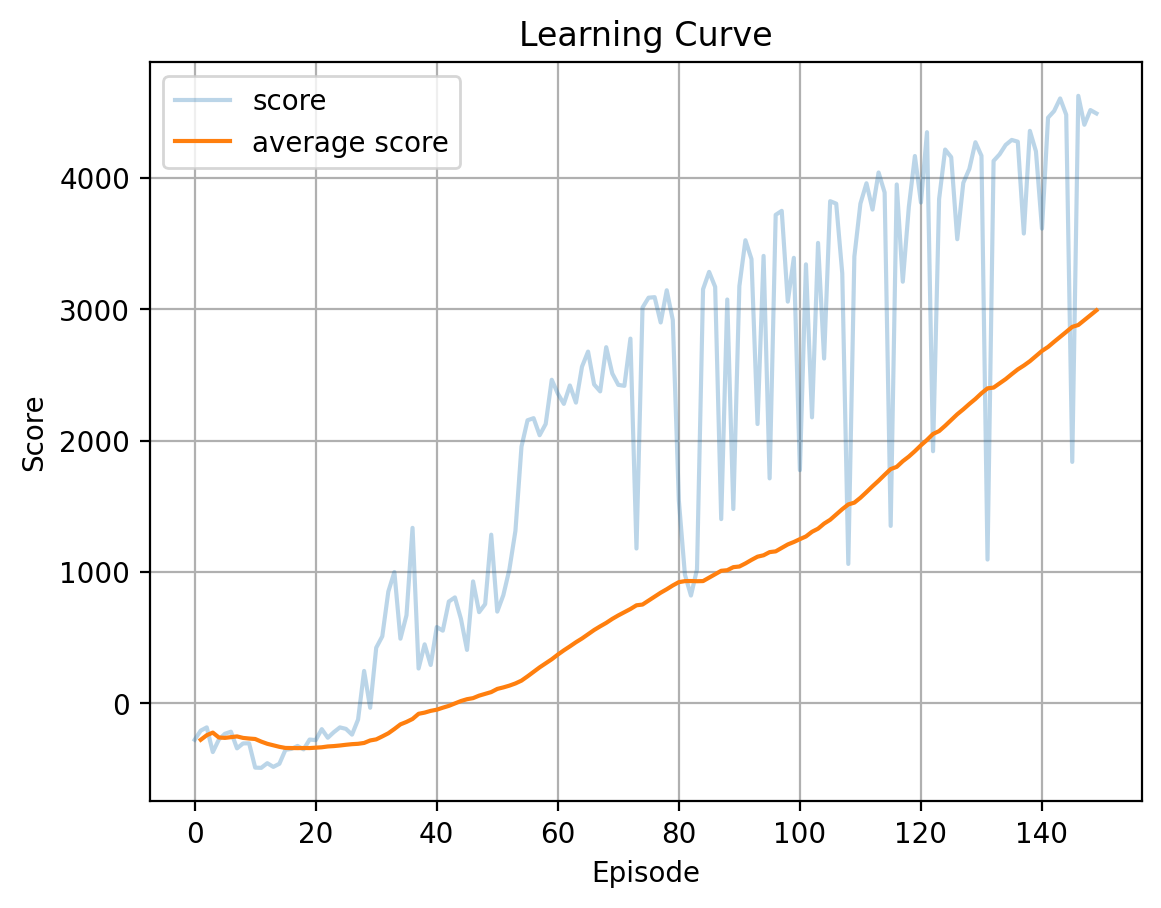

In [32]:
env = gym.make(env_name,render_mode="rgb_array")
dir_path = os.path.join(dir, env_name)
os.makedirs(dir_path, exist_ok=True)

if record_video:
    env = RecordVideo(env, video_folder=os.path.join(dir_path, 'videos'),
                      episode_trigger=lambda ep: ep == n_games - 1)


state_dims = env.observation_space.shape[0]
action_dims = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

agent = Agent(
    gamma=gamma, alpha=alpha, beta=beta,
    state_dims=state_dims, action_dims=action_dims, max_action=max_action,
    fc1_dim=fc1_dim, fc2_dim=fc2_dim,
    memory_size=memory_size, batch_size=batch_size, tau=tau,
    update_period=update_period, reward_scale=reward_scale,
    warmup=warmup, reparam_noise_lim=reparam_noise_lim,
    name='SAC', ckpt_dir=dir_path
)

# TODO: Initialize performance tracking variables
scores = []
best_score = -np.inf
avg_score = 0
total_steps = 0


for game in trange(n_games):
    # TODO: Reset environment and initialize variables at the start of each episode
    try:
        observation, _ = env.reset()
    except Exception:
        observation = env.reset()
    done = False
    score = 0.0

    # TODO: Interact with the environment until the episode is done
    while not (done):
        # Choose action
        action = agent.choose_action(observation, deterministic=False, reparameterize=False)

        # Take action in environment
        try:
            observation_, reward, terminated, truncated, info = env.step(action)
            done = bool(terminated or truncated)
        except Exception:
            observation_, reward, done, info = env.step(action)
            done = bool(done)

        # Store transition
        agent.store_transition(observation, action, reward, observation_, done)

        # Learn from experience
        agent.learn()

        # Update for next iteration
        observation = observation_
        score += reward
        total_steps += 1


    # TODO: Track score and average score for plotting and saving
    scores.append(score)
    avg_score = np.mean(scores[-100:])
    is_best = True if score > best_score else False
    best_score = score if score > best_score else best_score

    print(f'| Game: {game:6.0f} | Score: {score:10.2f} | Best score: {best_score:10.2f} | '
          f'Avg score {avg_score:10.2f} | Learning iter: {agent.learn_iter:10.0f} |')

    if game % 50 == 0:
        # Test with deterministic policy (no exploration noise)
        test_score = 0
        try:
            test_obs, _ = env.reset()
        except Exception:
            test_obs = env.reset()
        test_done = False
        while not test_done:
            action = agent.choose_action(test_obs, deterministic=True)  # DETERMINISTIC
            try:
                next_obs, reward, terminated, truncated, info = env.step(action)
                test_done = bool(terminated or truncated)
            except Exception:
                next_obs, reward, test_done, info = env.step(action)
                test_done = bool(test_done)
            test_score += reward
            test_obs = next_obs
        print(f"Test Score (deterministic): {test_score:.2f}")

    # TODO: Save the model if the current avg score is better than the best so far
    if game > 900 and is_best:
        agent.save_model()


env.close()

plot_learning_curve(scores, agent.full_path)

## 🎥 Visualize Agent Behavior

This is the last episode recorded video of the trained agent interacting with the environment in training process.

In [37]:
video_path = r"./tmp/HalfCheetah-v4/videos/rl-video-episode-{}.mp4".format(n_games-1)

Video(video_path, embed=True, width=600)